In [1]:
# load helper functions
%run MB_thresholding_helper_functions.py

In [2]:
# data loading
expt_name = 'Ecad-bcat_TGFb' # name of experiment folder

# replace /path/to/folder/ below with path to experiment folder
dir_path = '/path/to/folder/'
root_dir = dir_path + expt_name + '/'

name_treated = 'Treatment'
name_control = 'Control'
wells_treated = ['A1', 'A2', 'A3']
wells_control = ['B1', 'B2', 'B3']

# intensity measure on which to base thresholding
intensity = 'IntegratedIntensity'

# the user should add the three csv files read in below to the experiment folder
cells_df = pd.read_csv(root_dir + 'Ecad-bcat_TGFb_Both_Cells.csv', decimal='.', sep=",")
blobs_df = pd.read_csv(root_dir + 'Ecad-bcat_TGFb_BlobsInCells.csv', decimal='.', sep=",")
image_df = pd.read_csv(root_dir + 'Ecad-bcat_TGFb_Image.csv', decimal='.', sep=",")

# note: if any of the three file shapes below have only one column it mean the csv was saved with a ',' for the decimal
print('cells df shape = ' + str(cells_df.shape))
print('blobs df shape = ' + str(blobs_df.shape))
print('image df shape = ' + str(image_df.shape))

cells df shape = (588879, 9)
blobs df shape = (588879, 56)
image df shape = (18, 174)


In [3]:
# extract required metadata
meta = image_df[['ImageNumber', 'Metadata_Well']]
meta

,ImageNumber,Metadata_Well
0,1,A1
1,2,A1
2,3,A1
3,4,A2
4,5,A2
5,6,A2
6,7,A3
7,8,A3
8,9,A3
9,10,B1


In [4]:
# checking image numbers in cells and blobs dataframes match those in the metadata
print(set(blobs_df['ImageNumber']))
print(set(cells_df['ImageNumber']))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


In [5]:
# extracting treated cell data and plotting for determining thresholds
meta_treated = meta.loc[meta['Metadata_Well'].isin(wells_treated)]
imnum_treated = meta_treated['ImageNumber'].astype(int)
blobs_treated = blobs_df.loc[blobs_df['ImageNumber'].isin(list(imnum_treated))]
cells_treated = cells_df.loc[cells_df['ImageNumber'].isin(list(imnum_treated))]
x_treated = blobs_treated['Intensity_' + intensity + '_FilteredTexRed'].reset_index(drop=True)
y_treated = blobs_treated['Intensity_' + intensity + '_FilteredAtto647'].reset_index(drop=True)

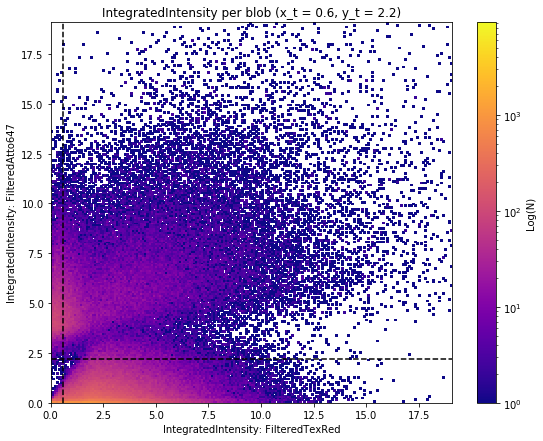

In [6]:
# determine new origin
x_t = 0.6
y_t = 2.2
plotter_initial_new_origin(x_treated, y_treated, x_t, y_t, intensity)

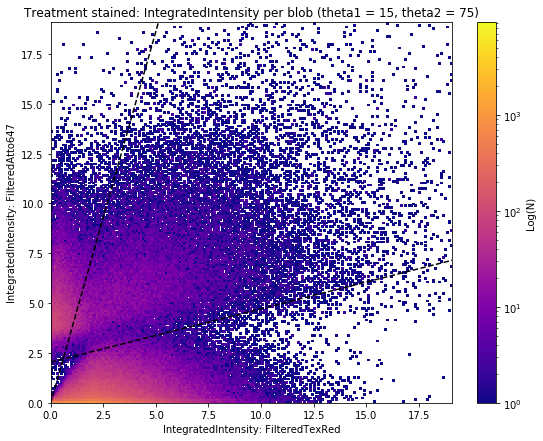

In [7]:
# setting thresholds for treated cells
theta1 = 15
theta2 = 75
m1, m2, c1, c2 = compute_slopes_and_intercepts(x_t, y_t, theta1, theta2)

# display and save thresholded plot to pdf
plotter_thresholds_new_origin(x_treated, y_treated, intensity, x_t, y_t, m1, m2, c1, c2, theta1, theta2,
                              name=name_treated, dir_path=dir_path, expt_name=expt_name)

In [8]:
# making treated dataframe, based on the thresholds set above
treated_df = df_maker_cells_new_origin(x_treated, y_treated, x_t, y_t, m1, m2, c1, c2,
                                       cells=cells_treated, condition=name_treated)

In [9]:
# extracting control cell data and plotting for determining thresholds
meta_control = meta.loc[meta['Metadata_Well'].isin(wells_control)]
imnum_control = meta_control['ImageNumber'].astype(int)
blobs_control = blobs_df.loc[blobs_df['ImageNumber'].isin(list(imnum_control))]
cells_control = cells_df.loc[cells_df['ImageNumber'].isin(list(imnum_control))]
x_control = blobs_control['Intensity_' + intensity + '_FilteredTexRed'].reset_index(drop=True)
y_control = blobs_control['Intensity_' + intensity + '_FilteredAtto647'].reset_index(drop=True)

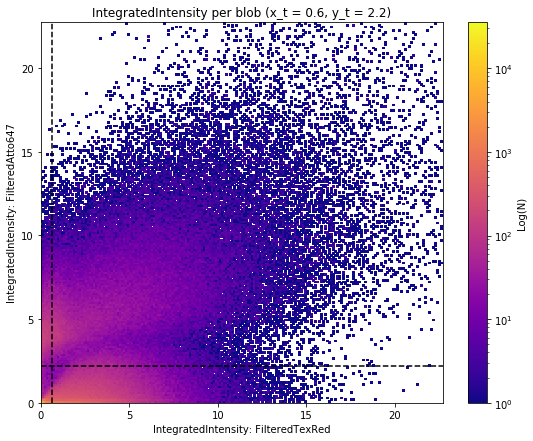

In [10]:
# determine new origin
x_t = 0.6
y_t = 2.2
plotter_initial_new_origin(x_control, y_control, x_t, y_t, intensity)

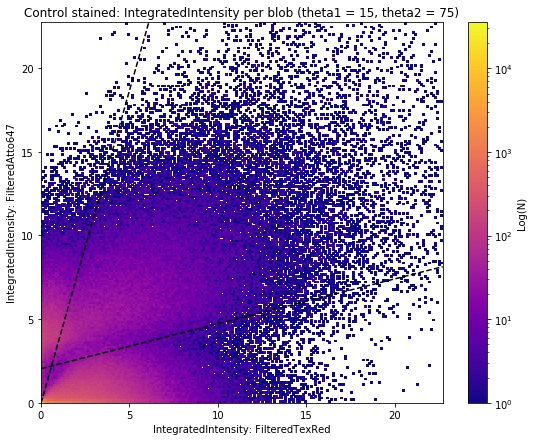

In [11]:
# setting thresholds for control cells
theta1 = 15
theta2 = 75
m1, m2, c1, c2 = compute_slopes_and_intercepts(x_t, y_t, theta1, theta2)

# display and save thresholded plot to pdf
plotter_thresholds_new_origin(x_control, y_control, intensity, x_t, y_t, m1, m2, c1, c2, theta1, theta2,
                              name=name_control, dir_path=dir_path, expt_name=expt_name)

In [12]:
# making treated dataframe, based on the thresholds set above
control_df = df_maker_cells_new_origin(x_control, y_control, x_t, y_t, m1, m2, c1, c2,
                                       cells=cells_control, condition=name_control)

In [13]:
# make final dataframe
final_df = pd.concat([treated_df, control_df], ignore_index=True, sort=False)
final_df

,Condition,ImageNumber,ParentCell,BlobCount,Category
0,Treatment,1,1,1726,TexRed
1,Treatment,1,1,578,Atto647
2,Treatment,1,1,652,Both
3,Treatment,1,2,1750,TexRed
4,Treatment,1,2,488,Atto647
...,...,...,...,...,...
1447,Control,18,43,49,Atto647
1448,Control,18,43,203,Both
1449,Control,18,44,205,TexRed
1450,Control,18,44,24,Atto647


In [14]:
# for this dataset the blob counts were scaled to proportions for each cell
# across the three conditions (TexRed, Atto647 and Both)

n = int(len(final_df) / 3)
scaler = np.zeros(n)

for i in range(n):
    low = i * 3
    high = low + 3
    scaler[i] = sum(final_df.iloc[low:high]['BlobCount'])

scaler = np.repeat(scaler, 3)

pd.options.mode.chained_assignment = None
final_df['BlobCount'] = final_df['BlobCount'] / scaler
final_df

,Condition,ImageNumber,ParentCell,BlobCount,Category
0,Treatment,1,1,0.583897,TexRed
1,Treatment,1,1,0.195535,Atto647
2,Treatment,1,1,0.220568,Both
3,Treatment,1,2,0.595238,TexRed
4,Treatment,1,2,0.165986,Atto647
...,...,...,...,...,...
1447,Control,18,43,0.081803,Atto647
1448,Control,18,43,0.338898,Both
1449,Control,18,44,0.672131,TexRed
1450,Control,18,44,0.078689,Atto647


In [15]:
# save final dataframe for plotting in R
final_df.to_csv(dir_path + expt_name + '_' + intensity + '.csv', index=False)